<a href="https://colab.research.google.com/github/vvshankar78/EVA4.0-Assignment-6/blob/master/EVA4_Assign6a_No_Norm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)


CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


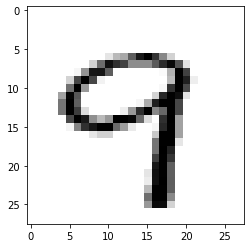

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

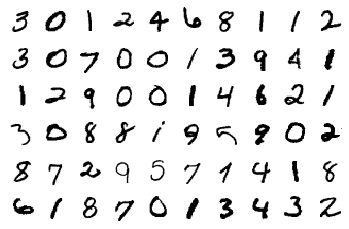

In [0]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output_size = 22
        

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3,3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU() 
        ) # output_size = 5

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU() 
        ) # output_size = 3

        # TRANSITION BLOCK 2
        #self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 5

        # self.convblock11 = nn.Sequential(
        #     nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3,3), padding=0, bias=False),
        #     #nn.ReLU() 
        # ) # output_size = 1

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        )
    

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        #x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.gap(x)
        #x = self.convblock11(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 16, 22, 22]           1,440
       BatchNorm2d-8           [-1, 16, 22, 22]              32
              ReLU-9           [-1, 16, 22, 22]               0
        MaxPool2d-10           [-1, 16, 11, 11]               0
           Conv2d-11           [-1, 10, 11, 11]             160
      BatchNorm2d-12           [-1, 10, 11, 11]              20
             ReLU-13           [-1, 10, 11, 11]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []                     
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # calculate Regularization
    wd = 5e-5   
    #L1 Loss
    w1 = 0.
    for p in model.parameters(): w1 += torch.sum(abs(p)) 

    # L2 Loss
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()

    # # Rohan's code
    # w3 = 0.
    # l1_crit = nn.L1Loss(reduce=False)
    # for p in model.parameters(): w3+=l1_crit(p)


    # Calculate loss
    #loss = F.nll_loss(y_pred, target) + w1*wd
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [0]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.11948502063751221 Batch_id=468 Accuracy=93.68: 100%|██████████| 469/469 [00:23<00:00, 19.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0810, Accuracy: 9854/10000 (98.54%)

EPOCH: 1


Loss=0.07000190019607544 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:23<00:00, 19.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0528, Accuracy: 9893/10000 (98.93%)

EPOCH: 2


Loss=0.10700837522745132 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:23<00:00, 19.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0441, Accuracy: 9908/10000 (99.08%)

EPOCH: 3


Loss=0.032875534147024155 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:23<00:00, 19.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0382, Accuracy: 9908/10000 (99.08%)

EPOCH: 4


Loss=0.08011379092931747 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:23<00:00, 19.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9920/10000 (99.20%)

EPOCH: 5


Loss=0.04500212147831917 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:23<00:00, 19.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9917/10000 (99.17%)

EPOCH: 6


Loss=0.02853993885219097 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:24<00:00, 19.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9908/10000 (99.08%)

EPOCH: 7


Loss=0.10610940307378769 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:23<00:00, 19.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9923/10000 (99.23%)

EPOCH: 8


Loss=0.04505835473537445 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:23<00:00, 19.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9933/10000 (99.33%)

EPOCH: 9


Loss=0.013948257081210613 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:24<00:00, 19.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9916/10000 (99.16%)

EPOCH: 10


Loss=0.02874629944562912 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:24<00:00, 19.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9923/10000 (99.23%)

EPOCH: 11


Loss=0.01112636923789978 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:24<00:00, 19.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9921/10000 (99.21%)

EPOCH: 12


Loss=0.009018759243190289 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:24<00:00, 24.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9926/10000 (99.26%)

EPOCH: 13


Loss=0.01335009466856718 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:24<00:00, 19.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9927/10000 (99.27%)

EPOCH: 14


Loss=0.019009843468666077 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:24<00:00, 19.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9925/10000 (99.25%)

EPOCH: 15


Loss=0.012221614830195904 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:24<00:00, 23.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9941/10000 (99.41%)

EPOCH: 16


Loss=0.03379148989915848 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:24<00:00, 19.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9936/10000 (99.36%)

EPOCH: 17


Loss=0.008447756059467793 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:23<00:00, 19.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9940/10000 (99.40%)

EPOCH: 18


Loss=0.018060609698295593 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:23<00:00, 24.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9940/10000 (99.40%)

EPOCH: 19


Loss=0.0017611434450373054 Batch_id=468 Accuracy=99.51: 100%|██████████| 469/469 [00:23<00:00, 20.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9936/10000 (99.36%)

EPOCH: 20


Loss=0.006425847765058279 Batch_id=468 Accuracy=99.57: 100%|██████████| 469/469 [00:23<00:00, 19.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9942/10000 (99.42%)

EPOCH: 21


Loss=0.038573574274778366 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:23<00:00, 24.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9931/10000 (99.31%)

EPOCH: 22


Loss=0.010778714902698994 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:23<00:00, 19.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9932/10000 (99.32%)

EPOCH: 23


Loss=0.04940454289317131 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:23<00:00, 19.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9935/10000 (99.35%)

EPOCH: 24


Loss=0.015197296626865864 Batch_id=468 Accuracy=99.62: 100%|██████████| 469/469 [00:23<00:00, 19.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9929/10000 (99.29%)

EPOCH: 25


Loss=0.0012480169534683228 Batch_id=468 Accuracy=99.62: 100%|██████████| 469/469 [00:24<00:00, 19.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9940/10000 (99.40%)

EPOCH: 26


Loss=0.0163103137165308 Batch_id=468 Accuracy=99.62: 100%|██████████| 469/469 [00:23<00:00, 25.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9931/10000 (99.31%)

EPOCH: 27


Loss=0.00788967777043581 Batch_id=468 Accuracy=99.68: 100%|██████████| 469/469 [00:24<00:00, 23.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9941/10000 (99.41%)

EPOCH: 28


Loss=0.02987702190876007 Batch_id=468 Accuracy=99.64: 100%|██████████| 469/469 [00:23<00:00, 25.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9935/10000 (99.35%)

EPOCH: 29


Loss=0.009993746876716614 Batch_id=468 Accuracy=99.68: 100%|██████████| 469/469 [00:23<00:00, 19.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9931/10000 (99.31%)

EPOCH: 30


Loss=0.015352974645793438 Batch_id=468 Accuracy=99.64: 100%|██████████| 469/469 [00:23<00:00, 19.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9943/10000 (99.43%)

EPOCH: 31


Loss=0.0028663177508860826 Batch_id=468 Accuracy=99.68: 100%|██████████| 469/469 [00:23<00:00, 23.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9929/10000 (99.29%)

EPOCH: 32


Loss=0.021586624905467033 Batch_id=468 Accuracy=99.66: 100%|██████████| 469/469 [00:24<00:00, 19.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9945/10000 (99.45%)

EPOCH: 33


Loss=0.004091307520866394 Batch_id=468 Accuracy=99.71: 100%|██████████| 469/469 [00:23<00:00, 19.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9933/10000 (99.33%)

EPOCH: 34


Loss=0.005926643963903189 Batch_id=468 Accuracy=99.74: 100%|██████████| 469/469 [00:23<00:00, 24.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9918/10000 (99.18%)

EPOCH: 35


Loss=0.003161077620461583 Batch_id=468 Accuracy=99.67: 100%|██████████| 469/469 [00:23<00:00, 26.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9931/10000 (99.31%)

EPOCH: 36


Loss=0.0069794305600225925 Batch_id=468 Accuracy=99.70: 100%|██████████| 469/469 [00:23<00:00, 19.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9943/10000 (99.43%)

EPOCH: 37


Loss=0.0023436297196894884 Batch_id=468 Accuracy=99.78: 100%|██████████| 469/469 [00:23<00:00, 19.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9920/10000 (99.20%)

EPOCH: 38


Loss=0.0028390984516590834 Batch_id=468 Accuracy=99.74: 100%|██████████| 469/469 [00:23<00:00, 19.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9937/10000 (99.37%)

EPOCH: 39


Loss=0.0014698505401611328 Batch_id=468 Accuracy=99.72: 100%|██████████| 469/469 [00:23<00:00, 19.80it/s]



Test set: Average loss: 0.0213, Accuracy: 9942/10000 (99.42%)



Text(0.5, 1.0, 'Test Accuracy')

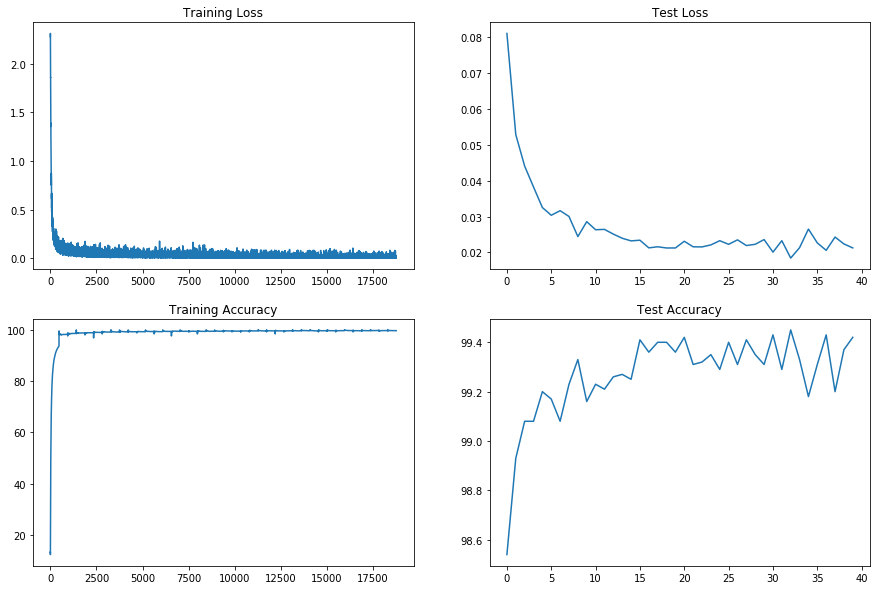

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [0]:
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=10000, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)


In [0]:
model.eval();

correct = 0
with torch.no_grad():
  for data,target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = (output.argmax(dim=1, keepdim=True)).cpu()
    print(data.shape)
    print(output.shape)
    print(target.shape)
    



torch.Size([10000, 1, 28, 28])
torch.Size([10000, 10])
torch.Size([10000])


# of misclassified images :  58


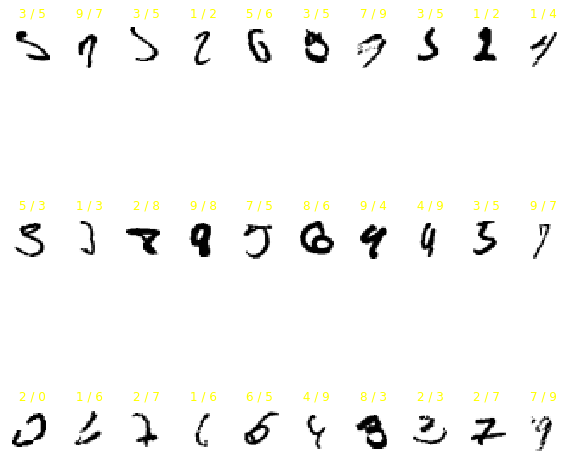

In [0]:

pred_ic = pred.cpu().numpy()
target_ic = target.view_as(pred).cpu().numpy()
data_ic =  data.cpu().numpy()

#print(pred_ic.shape, target_ic.shape, data_ic.shape)

test_incorrect = []
for i in range(10000):
  if pred_ic[i] != target_ic[i]:
    test_incorrect.append(i)

#print(test_incorrect[0:5])
print("# of misclassified images : ", len(test_incorrect))

figure = plt.figure(figsize=(10,10))
num_of_images = 30
for index in range(1, num_of_images+1):
  plt.subplot(3,10,index)
  plt.axis('off')
  plt.title(" %d / %d" % (pred_ic[test_incorrect[index]],target_ic[test_incorrect[index]]), color='yellow')
  plt.imshow(data_ic[test_incorrect[index]].squeeze(),cmap='gray_r')
